In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

# Data Preprocessing

Create a dataset based off of our cleaned images

In [2]:
# Parameters
data_dir = pathlib.Path('../cleaned') 
print(data_dir)
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
# We have a 70/30 split here, we split the training and testing once
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

../cleaned
Found 911 files belonging to 2 classes.
Using 638 files for training.
Found 911 files belonging to 2 classes.
Using 273 files for validation.


2025-01-10 14:47:27.441730: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


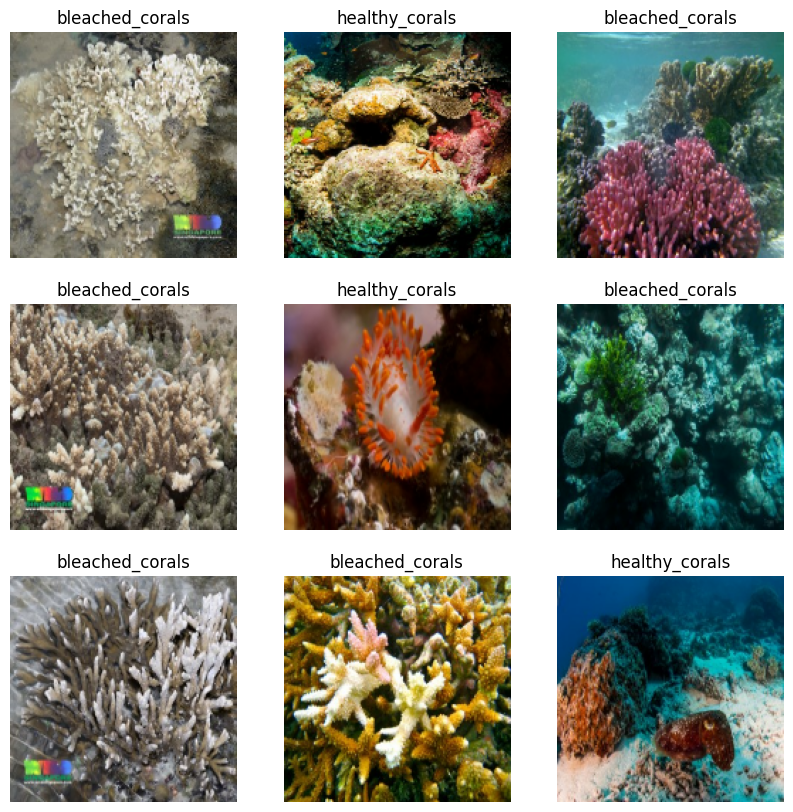

In [3]:
# Showing some images
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
# We're making a test set now
val_batches = tf.data.experimental.cardinality(val_ds) # gets number of batches and splits it into 20/80
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# are these numbers concerning?

Number of validation batches: 8
Number of test batches: 1


### Configuring Dataset

In [6]:
# Just prepares image so that they're easy to use, makes it optimal for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

2025-01-10 14:47:28.017725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


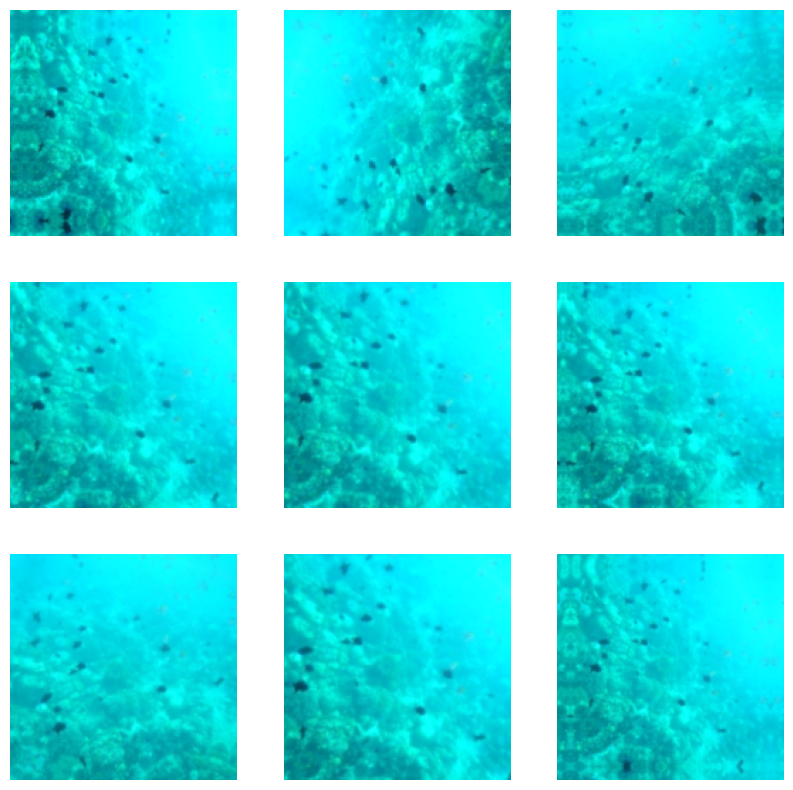

In [7]:
# augmenting data
data_augmentation = tf.keras.Sequential([
       tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ])

# This is essentially what the augmented data woukd look like
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
# images are currently in a (0,255) pixel format, so we transform for transfer learning
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
# Create base model based off of Google's Mobile Net, we will use the 'bottleneck' layer for feature extraction, 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # 5 by 5 and 1280 features

(32, 5, 5, 1280)


## Feature Extraction

In [10]:
# freeze base model layers so that their weights remain the same
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# transforms image / bottleneck layer into a format that we can make predictions for.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# make predicition layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [12]:
# Building new model based on what we have
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Maybe we could change the dropout rate?
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Compiling Model

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])



# Try a CNN model, it can ignore the empty pixels and wide pixels

In [16]:
initial_epochs = 13
loss0, accuracy0, precision0, recall0 = model.evaluate(validation_dataset) # calculate loss and accuracy
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5210 - loss: 0.7218 - precision: 0.4737 - recall: 0.4825
initial loss: 0.73
initial accuracy: 0.53
initial precision: 0.49
initial recall: 0.46


In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset) # accuracy on ten epochs, ours is pretty bad right now

Epoch 1/13
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.5660 - loss: 0.7316 - precision: 0.5627 - recall: 0.4511 - val_accuracy: 0.5768 - val_loss: 0.7123 - val_precision: 0.5500 - val_recall: 0.5789
Epoch 2/13
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.5910 - loss: 0.6909 - precision: 0.5737 - recall: 0.5483 - val_accuracy: 0.5892 - val_loss: 0.7035 - val_precision: 0.5512 - val_recall: 0.6250
Epoch 3/13
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.5990 - loss: 0.6777 - precision: 0.5886 - recall: 0.5374 - val_accuracy: 0.5892 - val_loss: 0.6868 - val_precision: 0.5538 - val_recall: 0.6372
Epoch 4/13
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.5894 - loss: 0.6708 - precision: 0.5734 - recall: 0.5738 - val_accuracy: 0.6224 - val_loss: 0.6639 - val_precision: 0.6032 - val_recall: 0.6496
Epoch 5/13
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.6074 - loss: 0.6769 - precision: 0.5840 - recall: 0.5394 - val_accuracy: 0.6349 - val_loss: 0

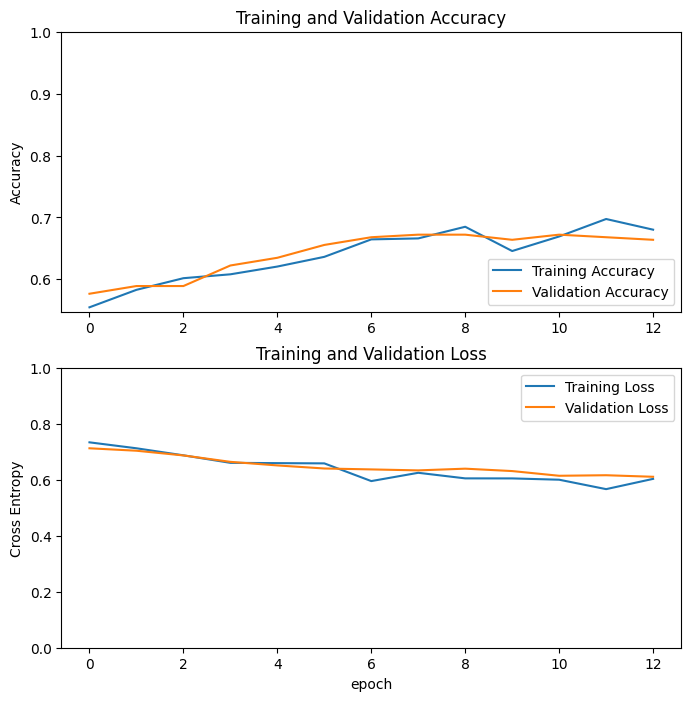

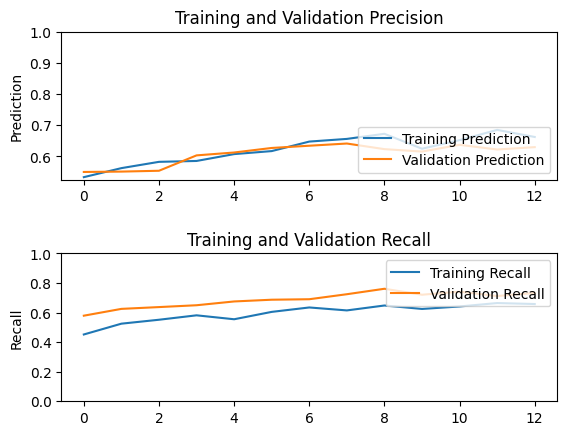

In [18]:
# charts showing accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Prediction')
plt.plot(val_precision, label='Validation Prediction')
plt.legend(loc='lower right')
plt.ylabel('Prediction')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.ylim([0,1.0])
plt.title('Training and Validation Recall')

plt.subplots_adjust(hspace=0.5)

plt.show()

# To keep the best model, save the model every time, use the same parameters
# If you want to avoid overfitting, in many cases dropping doesn't make a big difference. Those two numbers
# don't make 

# Try different epochs and different results. See if there's any patterns, around this range of batch sizes we get consistently
# better results. 

# Sometimes you can try twenty vs eighty,

In [19]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards, how do I decide whether to improve this?
fine_tune_at = 70

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 2,094,465 (7.99 MB)

 Non-trainable params: 164,800 (643.75 KB)

In [21]:
fine_tune_epochs = 13
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 14/26
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.6098 - loss: 0.7049 - precision: 0.6945 - recall: 0.3771 - val_accuracy: 0.6680 - val_loss: 0.5821 - val_precision: 0.6667 - val_recall: 0.5965
Epoch 15/26
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 377ms/step - accuracy: 0.6168 - loss: 0.6686 - precision: 0.6439 - recall: 0.4575 - val_accuracy: 0.6971 - val_loss: 0.5636 - val_precision: 0.7021 - val_recall: 0.5946
Epoch 16/26
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.7073 - loss: 0.6005 - precision: 0.7722 - recall: 0.5219 - val_accuracy: 0.6888 - val_loss: 0.5679 - val_precision: 0.7222 - val_recall: 0.5652
Epoch 17/26
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.7024 - loss: 0.5496 - precision: 0.7649 - recall: 0.5634 - val_accuracy: 0.7012 - val_loss: 0.5510 - val_precision: 0.7333 - val_recall: 0.5789
Epoch 18/26
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.7280 - loss: 0.5366 - precision: 0.7714 - recall: 0.6299 - val_accuracy: 0.6763 - val_lo

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

precision += history.history['precision']
val_precision += history.history['val_precision']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

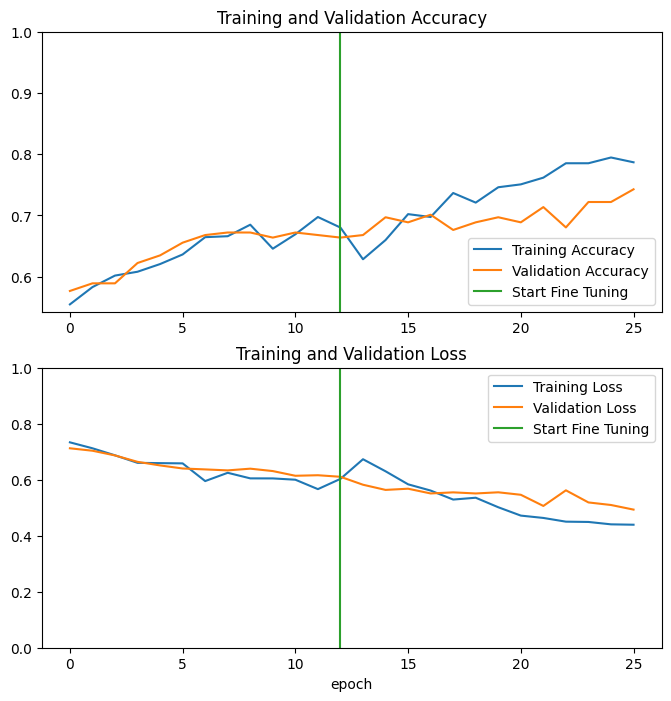

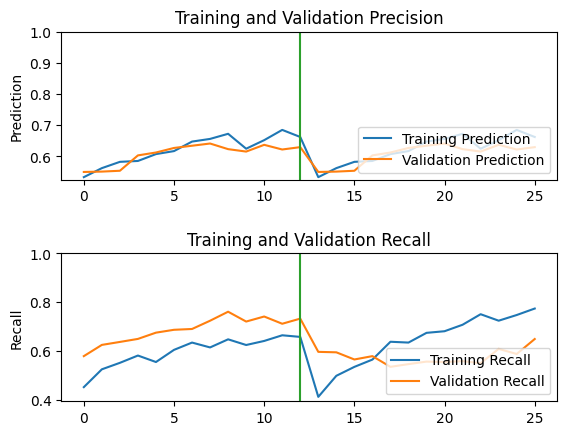

In [23]:
# This chart didn't exactly work
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Prediction')
plt.plot(val_precision, label='Validation Prediction')
plt.legend(loc='lower right')
plt.ylabel('Prediction')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Recall')

plt.subplots_adjust(hspace=0.5)

plt.show()


In [24]:
loss, accuracy, prec, rec = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8125 - loss: 0.4319 - precision: 0.9091 - recall: 0.6667
Test accuracy : 0.8125


In [25]:
# model.save('../models/model5.keras')
# Model 1 had test accuracy of 81
# Model 2 had test accuracy of 68
# Model 3 had test accuracy of 84
# Model 4 has test accuracy of 81
# Model 5 has test accuracy of 87.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
0.20085777


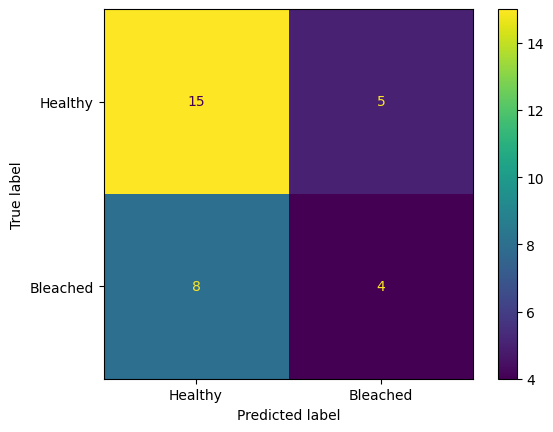

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred_prob = model.predict(test_dataset)  # Predicted probabilities

print(y_pred_prob[0][0])
y_pred = (y_pred_prob > 0.5).astype('int32').flatten() 
y_true = []

for images, labels in test_dataset:
    y_true.append(labels.numpy())

y_true = np.concatenate(y_true, axis=0)
# y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Bleached'])
disp.plot()

In [28]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
from tensorflow import keras

imageTransformed = keras.utils.load_img('../cleaned/bleached_corals/8517429_68924ed843_o.jpg', target_size=(160,160), color_mode="rgb", keep_aspect_ratio=False)
input_arr = keras.utils.img_to_array(imageTransformed)
input_arr = np.array([input_arr])

print(input_arr)

model.predict(input_arr)

[[[[ 65.  78.  94.]
   [ 39.  54.  73.]
   [ 39.  60.  81.]
   ...
   [107. 142. 135.]
   [162. 194. 189.]
   [159. 191. 188.]]

  [[ 66.  80.  93.]
   [ 50.  66.  82.]
   [ 44.  65.  84.]
   ...
   [161. 190. 186.]
   [163. 189. 190.]
   [156. 180. 184.]]

  [[ 54.  66.  80.]
   [ 42.  58.  73.]
   [ 44.  65.  82.]
   ...
   [155. 181. 178.]
   [160. 184. 188.]
   [149. 172. 178.]]

  ...

  [[ 86. 159. 176.]
   [ 77. 149. 164.]
   [ 88. 153. 171.]
   ...
   [ 33.  55.  68.]
   [ 24.  44.  43.]
   [ 38.  57.  51.]]

  [[ 85. 152. 168.]
   [ 81. 147. 163.]
   [ 88. 149. 167.]
   ...
   [ 31.  53.  66.]
   [ 30.  48.  48.]
   [ 48.  65.  57.]]

  [[ 79. 147. 158.]
   [ 90. 149. 163.]
   [ 95. 143. 153.]
   ...
   [ 28.  44.  44.]
   [ 32.  51.  47.]
   [ 25.  50.  46.]]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


array([[0.09642464]], dtype=float32)